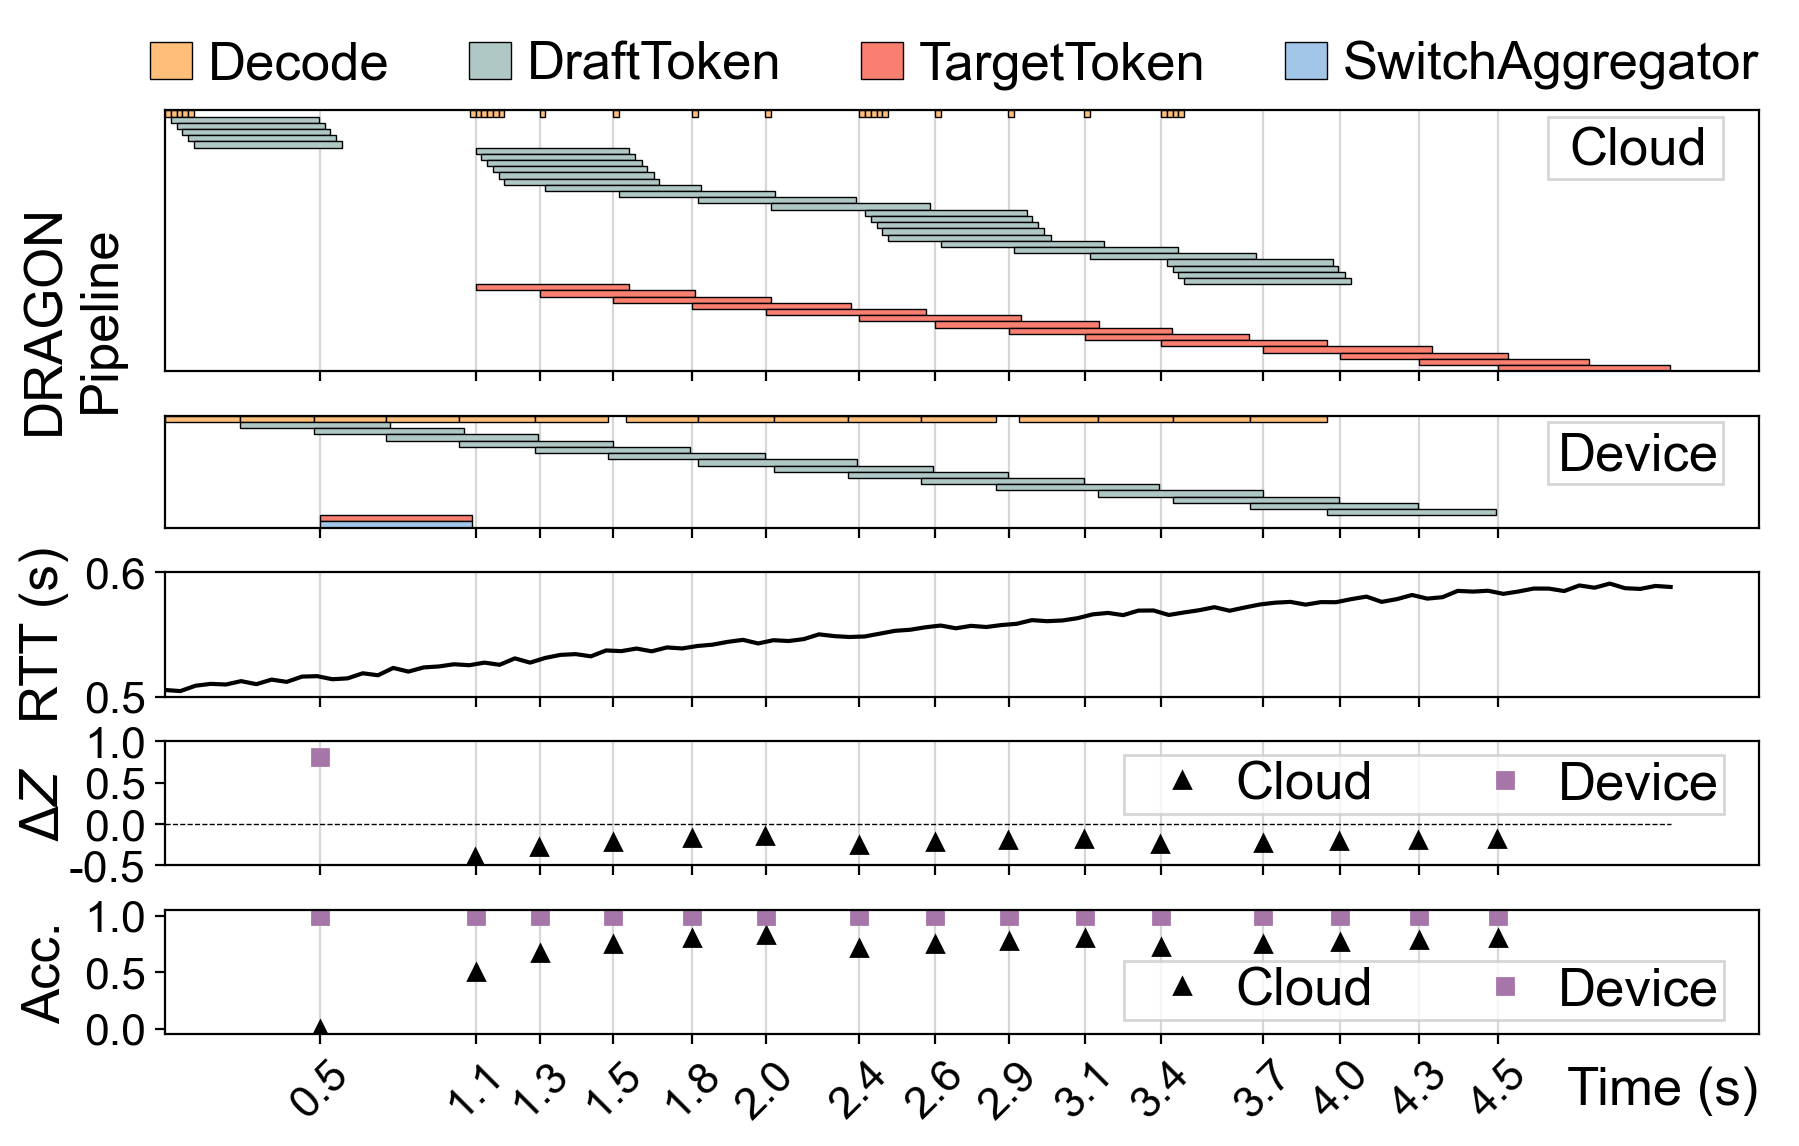

In [1]:
import pickle
import sys
from typing import OrderedDict; sys.path.append("..")
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np

import plt_utils
from experiments.Scheduling.simulator import Message
from experiments.Scheduling.eval_case_study import latency_trace

with open("../outputs/scheduling_case.pkl", "rb") as f:
    world, acceptance_stats = pickle.load(f)

font = plt_utils.Font("arial", size=19)
font_ticks = plt_utils.Font("arial", size=16)
colors = {
    "Decode": '#FFBE7A',
    Message.DRAFT: '#AFC8C6',
    Message.TARGET: '#F98070',
    Message.TURNON_AGGREGATOR: '#A1C6E7'
}
auxiliary_vline_color = "blue"
bar_height = 0.1

records = OrderedDict({
    title: [[], []] for title in ["Decode", Message.DRAFT, Message.TARGET, Message.TURNON_AGGREGATOR]
})
for record in world.records:
    src_id = record.meta.get('src_id', record.meta.get('rank'))
    records[record.title][src_id].append((record.beg_time, record.duration))
total_records = [sum([len(items[src_id]) if title != "Decode" else 1 for title, items in records.items()]) for src_id in (0, 1)]

figure, axes = plt.subplots(
    nrows=5, ncols=1, sharex=True, 
    figsize=(world.wall_time * 2, sum(total_records) / 10), 
    gridspec_kw={
        'height_ratios': total_records + [20, 20, 20],
        'hspace': 0.3
    }, 
    dpi=200
)
for src_id in (0, 1):
    cum_height = 0
    for title, items in records.items():
        for beg_time, duration in items[src_id]:
            if title != "Decode":
                cum_height -= bar_height
            axes[src_id].add_patch(patches.Rectangle(
                xy=(beg_time, cum_height), width=duration, height=bar_height, 
                edgecolor='black', facecolor=colors[title], linewidth=0.5, zorder=2, label=title.replace("TurnOnAggregator", "SwitchAggregator")))
    axes[src_id].set_yticks([])
    axes[src_id].set_ylim(cum_height, bar_height)
    axes[src_id].set_xticks(np.arange(0, world.wall_time, int(10 * (world.wall_time / 10)) / 10))
    axes[src_id].set_xlim(0, world.wall_time)
    axes[src_id].grid(zorder=1, alpha=0.5)
axes[0].set_ylabel("DRAGON\nPipeline", fontproperties=font)
handles, labels = axes[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[0].legend(
    by_label.values(), by_label.keys(),
    prop=font, loc='upper right', bbox_to_anchor=(1.03, 1.45),
    ncol=5, labelspacing=0.2, columnspacing=1.5, 
    frameon=False, handlelength=0.8, handletextpad=0.3
)

# Network latency
wall_time_axis = np.linspace(0, world.wall_time, num=100)
axes[2].plot(wall_time_axis, [latency_trace(t) for t in wall_time_axis], color='k')
axes[2].set_ylim(0.5, 0.6)
axes[2].set_ylabel('RTT (s)', fontproperties=font)
axes[2].set_yticks([0.5, 0.6])
axes[2].set_yticklabels([f"{y:.1f}" for y in [0.5, 0.6]], fontproperties=font_ticks)


# Scheduling strategy output
if world.get_entity_by_id(0).scheduler.delta_zs:
    wall_time_axis, delta_zs = list(zip(*world.get_entity_by_id(0).scheduler.delta_zs))
    wall_time_axis = np.array(wall_time_axis) + 0.008  # compensate the simulation precision loss, align x_axis, do not affect results
    axes[3].plot(wall_time_axis, delta_zs, marker='^', linestyle='none', label="Cloud", color='k')
if world.get_entity_by_id(1).scheduler.delta_zs:
    wall_time_axis, delta_zs = list(zip(*world.get_entity_by_id(1).scheduler.delta_zs))
    wall_time_axis = np.array(wall_time_axis) + 0.008  # compensate the simulation precision loss, align x_axis, do not affect results
    axes[3].plot(wall_time_axis, delta_zs, marker='s', linestyle='none', label="Device", color='#A676A9')
axes[3].hlines(y=0, xmin=0, xmax=world.wall_time, color='k', linestyle='--', lw=0.5)
axes[3].set_ylabel('$\Delta Z$', fontproperties=font)
axes[3].set_yticks(np.arange(-0.5, 1.1, 0.5))
axes[3].set_yticklabels([f"{y:.1f}" for y in np.arange(-0.5, 1.1, 0.5)], fontproperties=font_ticks)


wall_time_axis = []
for src_id in (0, 1):
    cum_height = 0
    for title, items in records.items():
        for beg_time, duration in items[src_id]:
            if title == Message.TARGET:
                wall_time_axis.append(beg_time)
wall_time_axis = sorted(wall_time_axis)
wall_time_label = [f"{t:.1f}" for t in wall_time_axis]

for ax in axes:
    ax.set_xticks(wall_time_axis)
    ax.set_xticklabels(wall_time_label, fontproperties=font_ticks, rotation=45)
    ax.grid(axis='x', zorder=1, alpha=0.5)
acceptance_cloud = []
acceptance_device = []
for i in range(1, len(acceptance_stats['Cloud']) + 1):
    acceptance_cloud.append(np.mean(acceptance_stats['Cloud'][: i]))
    acceptance_device.append(np.mean(acceptance_stats['Device'][: i]))
axes[4].plot(wall_time_axis, acceptance_cloud, label='Cloud', marker='^', color='k', linestyle='none')
axes[4].plot(wall_time_axis, acceptance_device, label='Device', marker='s', color='#A676A9', linestyle='none')
axes[4].set_ylabel('Acc.', fontproperties=font)
for ax in axes:
    ax.yaxis.set_label_coords(-0.06, 0.5)
axes[0].yaxis.set_label_coords(-0.025, 0.2)
    
axes[4].set_yticks([0, 0.5, 1])
axes[4].set_yticklabels([f"{y:.1f}" for y in [0, 0.5, 1]], fontproperties=font_ticks)

axes[3].legend(loc='upper right', bbox_to_anchor=(0.995, 1.1), frameon=True, handletextpad=0., ncols=2, prop=font, labelspacing=0., columnspacing=1.5, borderpad=0.1, fancybox=False)
axes[4].legend(loc='upper right', bbox_to_anchor=(0.995, 0.8), frameon=True, handletextpad=0., ncols=2, prop=font, labelspacing=0., columnspacing=1.5, borderpad=0.1, fancybox=False)

axes[0].add_patch(patches.Rectangle(
    xy=(world.wall_time - 0.42, -1), width=0.6, height=1, 
    linewidth=1, edgecolor='#D6D6D6', facecolor=(1, 1, 1, 0.5), zorder=2,
))
axes[1].add_patch(patches.Rectangle(
    xy=(world.wall_time - 0.42, -1), width=0.6, height=1, 
    linewidth=1, edgecolor='#D6D6D6', facecolor=(1, 1, 1, 0.5), zorder=2,
))
axes[0].text(world.wall_time - 0.11, -0.55, 'Cloud', fontproperties=font, ha='center', va='center')
axes[1].text(world.wall_time - 0.11, -0.55, 'Device', fontproperties=font, ha='center', va='center')
axes[4].set_xlabel('Time (s)', fontproperties=font)
axes[4].xaxis.set_label_coords(0.94, -0.25)
for ax in axes:
    ax.set_xlim(0, world.wall_time + 0.3)
plt.savefig("figures/scheduling_case.pdf", bbox_inches='tight')
figure.show()